In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob


In [10]:
def eofs_GA(inxarr, variables=['u','v'], neofs=10, time_name='time', npcs=5, treshold=None):
    tmp=inxarr[variables]
    tmp=tmp.to_stacked_array('z_loc',sample_dims=[time_name]).fillna(0)
    solver = Eof(tmp)
 
    out=solver.eofs(neofs=neofs).to_unstacked_dataset('z_loc').unstack()
    #xr.Dataset()
    out['X']=inxarr['X']
    out['Y']=inxarr['Y']
    out['time']=inxarr['time']
    out['eigenvals']=solver.eigenvalues()
    out['land_binary_mask']=inxarr['land_binary_mask']
    #if treshold < lmbda.mode.max(): 
    #    np.searchsorted(lmbda.cumsum()/lmbda.sum(),[0.9,],side='right')[0]
    # eofs=solver.eofs(neofs=5).to_unstacked_dataset('z_loc').unstack()
    # out['eofs_u']=eofs['u']
    # out['eofs_v']=eofs['v']
    out['speed']=np.sqrt(out.u**2+out.v**2)
    angles=np.arctan2(out['v'],out['u'])
    out['direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)
    out['pcs']=solver.pcs(npcs=npcs)

    return out

    

In [11]:
def plot_eofs(res,name='',save_dir='',save=False):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.7)
    fig.suptitle("Eofs" + name, fontsize=18, y=0.95)
    axes=axs.ravel()
    res.pcs.isel(mode=[0,1,2,3]).plot.line(x='time',ax=axes[0])
    (res.eigenvals[0:10].cumsum()/res.eigenvals.sum()).plot(marker='x',ax=axes[1])
    res.eigenvals[0:10].plot(marker='o',color='r',ax=axes[1].twinx())
    
    for mode in np.arange(4):
        res.isel(mode=mode).where(res.land_binary_mask==0).plot.quiver(x='X',y='Y' ,u='u', v='v',hue='u',ax=axes[mode+2])

    if save:
        plt.savefig(save_dir+name+'.jpg')

In [12]:
data=xr.open_dataset('byfjordenSubset.nc')

In [13]:
May=data.isel(time=data.time.dt.month.isin(5))

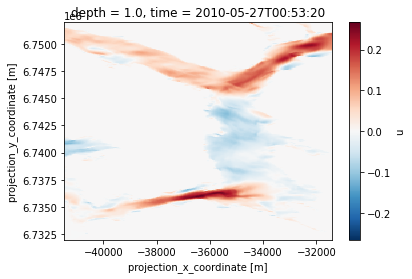

In [21]:
(May.isel(depth=0,time=351).u-May.isel(depth=0).u.mean(dim='time')).plot()

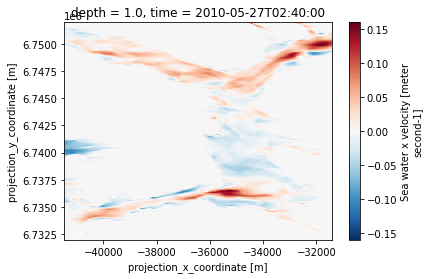

In [23]:
May.isel(depth=0,time=352).u.plot()

In [28]:
May.isel(depth=0)

<xarray.Dataset>
Dimensions:           (time: 418, Y: 400, X: 201)
Coordinates:
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-05-01T00:53:20 ... 2010-05-3...
Data variables:
    u                 (time, Y, X) float32 ...
    v                 (time, Y, X) float32 ...
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 23.12 ... 0.0 0.0 0.0 0.0
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [31]:
Maym=May.isel(depth=0).copy()
Maym['u']=Maym.u-Maym.u.mean(dim='time')
Maym['v']=Maym.v-Maym.v.mean(dim='time')

In [32]:
res=eofs_GA(Maym,neofs=None)
res['land_binary_mask']=May['land_binary_mask']
res

init_dgesdd failed init


<xarray.Dataset>
Dimensions:           (mode: 418, Y: 400, X: 201, time: 418)
Coordinates:
  * mode              (mode) int64 0 1 2 3 4 5 6 ... 411 412 413 414 415 416 417
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-05-01T00:53:20 ... 2010-05-3...
Data variables:
    u                 (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    v                 (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    eigenvals         (mode) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    speed             (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    direction         (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pcs               (time, mode) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan

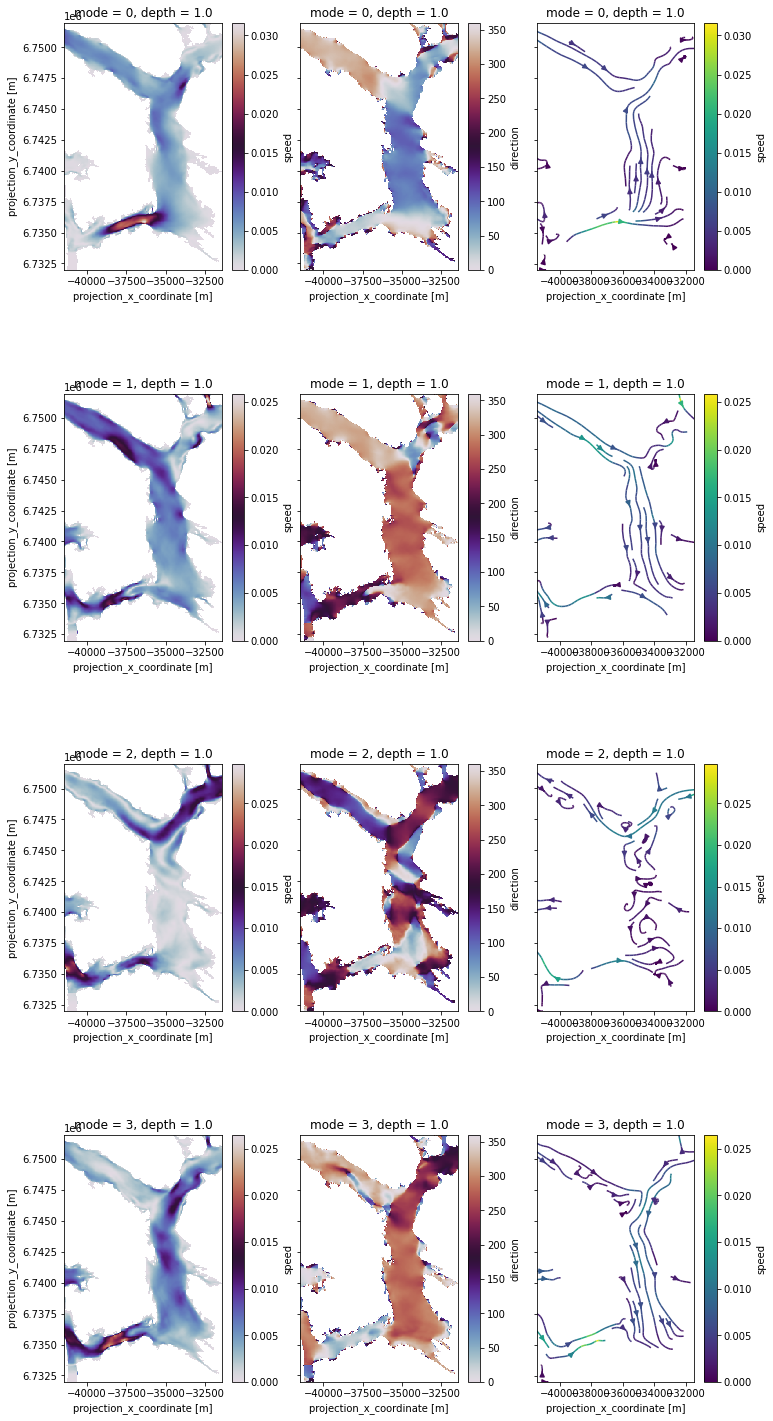

In [27]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 25))
plt.subplots_adjust(hspace=0.5)
axes=axs.ravel()
for mode in np.arange(4):
    res['speed'].where(res.land_binary_mask==0).isel(mode=mode).plot(ax=axes[3*mode],cmap='twilight')
    
    res['direction'].where(res.land_binary_mask==0).isel(mode=mode).plot(cmap='twilight',ax=axes[3*mode+1])
    res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v',hue='speed',ax=axes[3*mode+2])
    axs[mode][1].set_ylabel('')
    axs[mode][1].set_yticklabels('')
    axs[mode][2].set_ylabel('')
    axs[mode][2].set_yticklabels('')


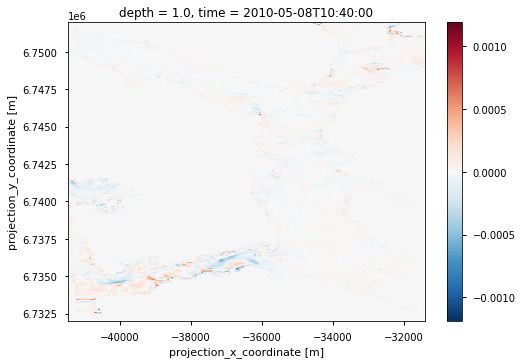

In [99]:
(May.isel(depth=0).u.differentiate(coord='X')+May.isel(depth=0).v.differentiate(coord='Y')).isel(time=100).plot()


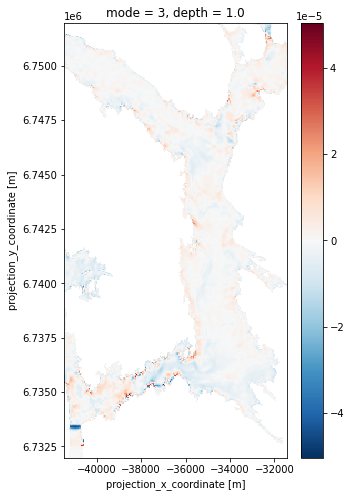

In [77]:
tmp=res.isel(mode=3)
(tmp.u.differentiate(coord='X')+tmp.v.differentiate(coord='Y')).where(res.land_binary_mask==0).plot(figsize=(5,8))


In [90]:
tmp[1]

<AxesSubplot:title={'center':'mode = 1, depth = 3.0'}, xlabel='projection_x_coordinate [m]', ylabel='projection_y_coordinate [m]'>

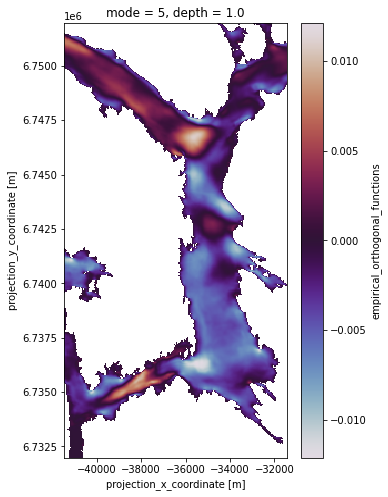

In [50]:
res['u'].where(res.land_binary_mask==0).isel(mode=5).plot(cmap='twilight',figsize=(5,8))

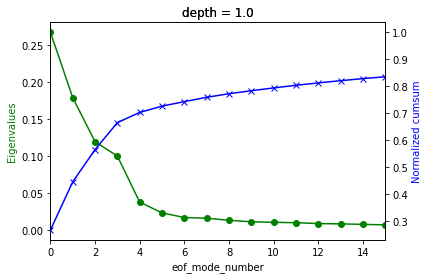

In [48]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
(res.eigenvals/res.eigenvals.sum()).plot(marker='o',color='g',ax=ax1)
(res.eigenvals.cumsum()/res.eigenvals.sum()).plot(color='b',marker='x',ax=ax2)

ax1.set_ylabel('Eigenvalues', color='g')
ax2.set_ylabel('Normalized cumsum', color='b')
plt.xlim(0,15)
plt.show()

(0.0, 5.0)

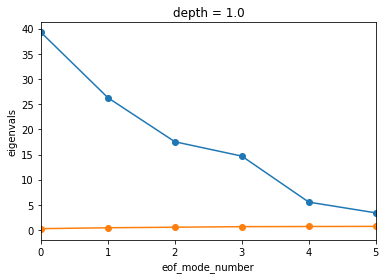

In [31]:
res.eigenvals.plot(marker='o')
(res.eigenvals.cumsum()/res.eigenvals.sum()).plot(marker='o')
plt.xlim(0,5)

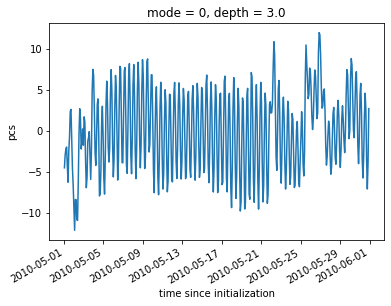

In [18]:
mode=0
res.pcs.isel(mode=mode).plot()

TypeError: __call__() takes 1 positional argument but 2 were given

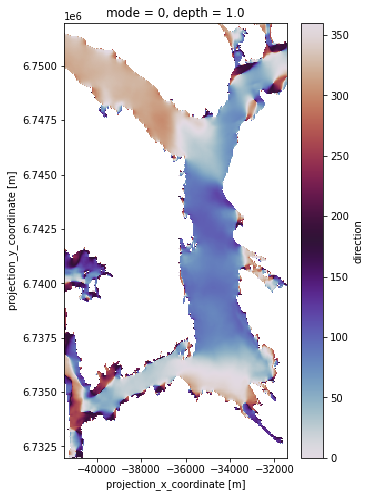

In [44]:
mode=10
res.direction.where(res.land_binary_mask==0).isel(mode=mode).plot()

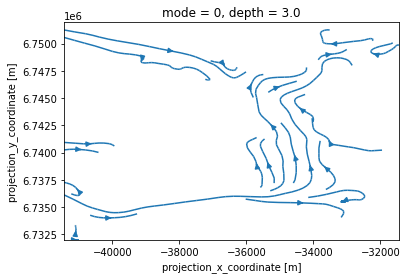

In [20]:
res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v')

In [113]:
help(xr.streamplot)

AttributeError: module 'xarray' has no attribute 'streamplot'

In [115]:
mode=4
tmp=(res.isel(mode=mode).pcs*res.isel(mode=mode).eigenvals)
tmp


<xarray.DataArray (time: 418)>
array([ 2.51191559e+01,  3.43576698e+01,  2.70350609e+01, -6.90878868e+00,
       -1.74213657e+01, -1.40487537e+01, -1.97940865e+01,  1.00656357e+01,
       -3.73587632e+00, -3.60380381e-01, -2.35856175e+00, -1.31972599e+00,
        4.25410423e+01,  7.04083099e+01,  4.00344772e+01, -5.73251247e+00,
       -1.60317554e+01, -1.57020779e+01, -1.47514153e+01, -1.57096205e+01,
       -1.64089279e+01, -1.43239803e+01, -1.14165907e+01, -2.42575722e+01,
       -5.26303368e+01,  3.73313560e+01,  5.59709435e+01,  9.72277546e+00,
       -1.40220869e+00, -5.83586979e+00, -5.90118408e+00, -3.76218820e+00,
        1.64434147e+01,  3.29918137e+01, -2.25301094e+01, -2.55837078e+01,
       -1.79004879e+01, -4.56511650e+01, -1.64342537e+01,  1.59816754e+00,
        7.08576250e+00,  3.00996566e+00,  6.32103741e-01,  1.37846696e+00,
        4.23830843e+00,  7.44553423e+00,  6.48577070e+00,  1.54397130e-01,
        4.01143951e+01, -1.38502455e+01,  1.22235184e+01, -7.12136936e+00,
       -7.84985685e+00, -1.17526674e+01, -1.27301912e+01, -1.05963640e+01,
       -1.13587770e+01, -8.01495266e+00, -3.98594689e+00, -1.42811193e+01,
       -2.55945563e+00, -1.58297396e+01,  2.40459251e+01,  8.79130363e+00,
        6.99451160e+00,  1.59862947e+00, -1.75135958e+00, -1.64975250e+00,
       -6.14190054e+00, -4.94580603e+00,  9.07736897e-01, -2.43802503e-01,
       -9.99710941e+00,  3.53043228e-01, -1.88284302e+01, -5.07494259e+00,
        2.14468288e+00,  2.38385424e-01, -7.97924566e+00, -4.85249901e+00,
...
        8.04285336e+00,  1.99379654e+01,  5.24168789e-01,  1.34703531e+01,
        4.16118956e+00,  1.04785514e+00, -2.66268682e+00, -2.62183208e+01,
       -5.69773674e+01, -4.00022507e+00,  2.31581593e+01,  1.88279190e+01,
        1.02514009e+01,  5.02461100e+00,  4.92792559e+00,  8.78254700e+00,
        1.20835199e+01,  1.27113161e+01,  1.04325953e+01,  6.80696106e+00,
        4.71250010e+00,  2.04208779e+00, -4.82542574e-01, -3.20232105e+00,
       -8.65886688e+00, -1.23804083e+01, -1.14530964e+01, -5.82128048e+00,
        6.08637631e-01,  2.64530611e+00,  2.94658560e-02, -3.36639309e+00,
       -5.08620930e+00, -5.91906118e+00, -1.98346651e+00, -6.93928838e-01,
       -3.81162310e+00, -1.08745260e+01, -1.19807243e+01, -1.07903414e+01,
       -4.38737202e+00,  8.65319633e+00, -2.78511524e+00, -2.76620502e+01,
        6.76414633e+00, -6.35042000e+00,  6.65179312e-01, -4.08597660e+00,
       -2.30468065e-02, -2.65089840e-01,  8.47981071e+00, -1.30473433e+01,
       -2.62149620e+01,  1.93823552e+00,  8.58087540e+00,  7.05244827e+00,
        6.99304962e+00,  6.60602951e+00, -5.28119326e-01,  1.10472040e+01,
        1.15295839e+01,  1.00335531e+01, -9.47922826e-01,  1.35852709e+01,
        2.80311370e+00, -5.82450247e+00,  2.05472541e+00,  1.98660803e+00,
       -5.46554041e+00, -8.06682873e+00,  1.21224232e+01,  1.92555122e+01,
        6.95254230e+00, -3.38021708e+00, -7.48701620e+00, -4.07501364e+00,
       -1.37264929e+01, -4.67563725e+00], dtype=float32)
Coordinates:
    mode     int64 4
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-05-01T00:53:20 ... 2010-05-31T22:13:20

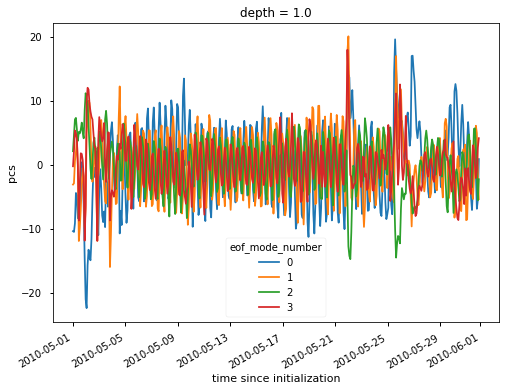

In [101]:
res.pcs.isel(mode=[0,1,2,3]).plot.line(x='time')

In [22]:
res

<xarray.Dataset>
Dimensions:           (mode: 10, Y: 400, X: 201, time: 1501)
Coordinates:
  * mode              (mode) int64 0 1 2 3 4 5 6 7 8 9
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    v                 (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    eigenvals         (mode) float32 28.59 19.41 14.78 ... 1.008 0.9224 0.8579
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    speed             (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    direction         (mode, Y, X) float32 90.0 90.0 270.0 90.0 ... 0.0 0.0 0.0
    pcs               (time, mode) float32 -12.16 -2.491 -1.415 ... nan nan nan

(6735000.0, 6737500.0)

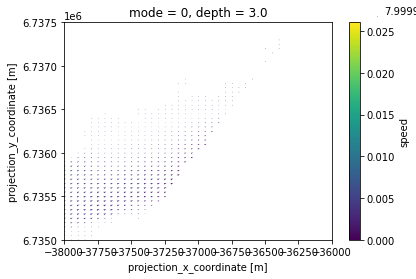

In [22]:
ix=98
iy=84
plt.clf()
res.isel(mode=mode).where(res.land_binary_mask==0).plot.quiver(x='X',y='Y' ,u='u', v='v',hue='speed')
plt.xlim(-38000,-36000)
plt.ylim(6735000,6737500)

In [28]:
res.time.diff(dim='time')/np.timedelta64(1, 'm')

<xarray.DataArray 'time' (time: 417)>
array([106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
...
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667, 106.66666667, 106.66666667, 106.66666667,
       106.66666667])
Coordinates:
    depth    float32 3.0
  * time     (time) datetime64[ns] 2010-05-01T02:40:00 ... 2010-05-31T22:13:20

In [48]:
res.time

<xarray.DataArray 'time' (time: 1501)>
array(['2010-03-27T16:00:00.000000000', '2010-03-27T17:46:40.000000000',
       '2010-03-27T19:33:20.000000000', ..., '2010-07-16T15:06:40.000000000',
       '2010-07-16T16:53:20.000000000', '2010-07-16T18:40:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    depth    float32 3.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

In [34]:
freq=res.time.diff(dim='time').mean()/np.timedelta64(1, 'h')
freq=1/freq
infreq=freq.values
infreq

array(0.5625)

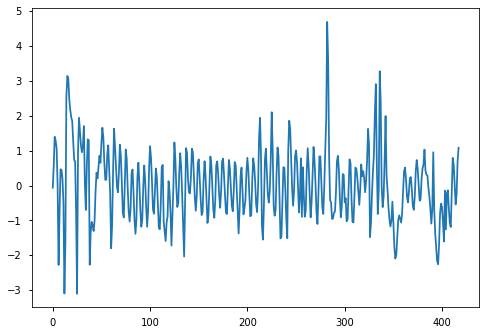

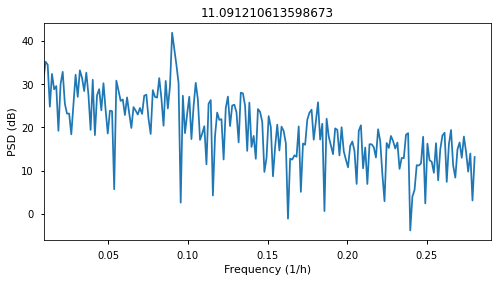

In [80]:
y=res.isel(mode=3).pcs.values
y=(y-np.mean(y))/np.std(y)
plt.plot(y)
fft_ga(y)

In [76]:
def fft_ga(y):
    temp_fft = sp.fft.fft(y)
    temp_psd = np.abs(temp_fft) ** 2
    fftfreq = sp.fft.fftfreq(len(temp_psd), 1/infreq)
    i = fftfreq > 0

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
    ax.set_xlim(0.01, 0.29)
    ax.set_xlabel('Frequency (1/h)')
    ax.set_ylabel('PSD (dB)')
    ax.set_title(1/fftfreq[temp_psd.argmax()])
    #%%
    f=abs(np.fft.fft(y))

    # get the list of frequencies
    num=np.size(f)
    freq = [i / num for i in list(range(num))]

# get the list of spectrums
    spectrum=f.real*f.real+f.imag*f.imag
    nspectrum=spectrum/spectrum[0]
    
# plot nspectrum per frequency, with a semilog scale on nspectrum
#plt.semilogy(nspectrum)

In [81]:
1/fftfreq[temp_psd.argmax()]

11.091210613598673

In [45]:
date2num(res.time)

array([14730.03703704, 14730.11111111, 14730.18518519, 14730.25925926,
       14730.33333333, 14730.40740741, 14730.48148148, 14730.55555556,
       14730.62962963, 14730.7037037 , 14730.77777778, 14730.85185185,
       14730.92592593, 14731.        , 14731.07407407, 14731.14814815,
       14731.22222222, 14731.2962963 , 14731.37037037, 14731.44444444,
       14731.51851852, 14731.59259259, 14731.66666667, 14731.74074074,
       14731.81481481, 14731.88888889, 14731.96296296, 14732.03703704,
       14732.11111111, 14732.18518519, 14732.25925926, 14732.33333333,
       14732.40740741, 14732.48148148, 14732.55555556, 14732.62962963,
       14732.7037037 , 14732.77777778, 14732.85185185, 14732.92592593,
       14733.        , 14733.07407407, 14733.14814815, 14733.22222222,
       14733.2962963 , 14733.37037037, 14733.44444444, 14733.51851852,
       14733.59259259, 14733.66666667, 14733.74074074, 14733.81481481,
       14733.88888889, 14733.96296296, 14734.03703704, 14734.11111111,
      

In [46]:

coef = solve(date2num(res.time), y, lat=60.0, method='robust',Rayleigh_min=0.9)#, constit=['M2'])#,nodal=True, rend=True, method='robust', conf_int='linear', Rayleigh_min=0.95)

tide = reconstruct(date2num(res.time), coef)

coef.keys()

solve: matrix prep ... solution ... done.
prep/calcs ... done.


dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'rf', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])

In [47]:
mode=0
ein=res.isel(mode=mode).direction.values.flatten()
ein

array([180., 180., 180., ...,   0.,   0.,   0.], dtype=float32)

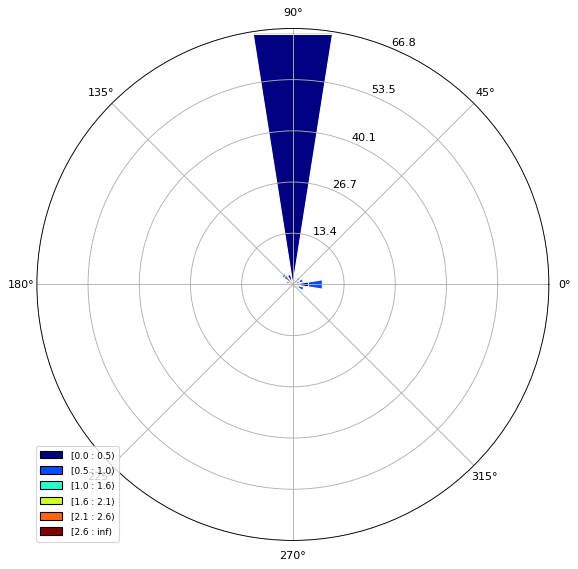

In [48]:

from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(res.isel(mode=mode).direction.values.flatten().squeeze(), 100*res.isel(mode=mode).speed.values.flatten(), normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

In [49]:
tide

{'t_in': array([14730.03703704, 14730.11111111, 14730.18518519, 14730.25925926,
        14730.33333333, 14730.40740741, 14730.48148148, 14730.55555556,
        14730.62962963, 14730.7037037 , 14730.77777778, 14730.85185185,
        14730.92592593, 14731.        , 14731.07407407, 14731.14814815,
        14731.22222222, 14731.2962963 , 14731.37037037, 14731.44444444,
        14731.51851852, 14731.59259259, 14731.66666667, 14731.74074074,
        14731.81481481, 14731.88888889, 14731.96296296, 14732.03703704,
        14732.11111111, 14732.18518519, 14732.25925926, 14732.33333333,
        14732.40740741, 14732.48148148, 14732.55555556, 14732.62962963,
        14732.7037037 , 14732.77777778, 14732.85185185, 14732.92592593,
        14733.        , 14733.07407407, 14733.14814815, 14733.22222222,
        14733.2962963 , 14733.37037037, 14733.44444444, 14733.51851852,
        14733.59259259, 14733.66666667, 14733.74074074, 14733.81481481,
        14733.88888889, 14733.96296296, 14734.03703704, 

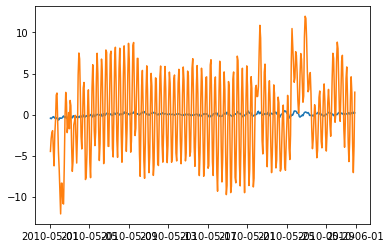

In [50]:
plt.plot(res.time,tide.h)
plt.plot(res.time,res.isel(mode=0).pcs)

In [51]:
tide

{'t_in': array([14730.03703704, 14730.11111111, 14730.18518519, 14730.25925926,
        14730.33333333, 14730.40740741, 14730.48148148, 14730.55555556,
        14730.62962963, 14730.7037037 , 14730.77777778, 14730.85185185,
        14730.92592593, 14731.        , 14731.07407407, 14731.14814815,
        14731.22222222, 14731.2962963 , 14731.37037037, 14731.44444444,
        14731.51851852, 14731.59259259, 14731.66666667, 14731.74074074,
        14731.81481481, 14731.88888889, 14731.96296296, 14732.03703704,
        14732.11111111, 14732.18518519, 14732.25925926, 14732.33333333,
        14732.40740741, 14732.48148148, 14732.55555556, 14732.62962963,
        14732.7037037 , 14732.77777778, 14732.85185185, 14732.92592593,
        14733.        , 14733.07407407, 14733.14814815, 14733.22222222,
        14733.2962963 , 14733.37037037, 14733.44444444, 14733.51851852,
        14733.59259259, 14733.66666667, 14733.74074074, 14733.81481481,
        14733.88888889, 14733.96296296, 14734.03703704, 

In [52]:
from matplotlib import style

style.use('seaborn-notebook')
t=tmpu.time
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True,  figsize=(17, 7))

ax0.plot(t, ein.u, label='Eastward')

ax0.legend(numpoints=1, loc='upper left')
ax0.set_title('Observations')


ax1.plot(t, tide['u'] )
ax1.plot(t, tide['v'])
ax1.set_title('Tide')
#ax1.legend(numpoints=1, loc='upper left')

ax2.plot(t, ein.u-tide['u'])
ax2.plot(t, ein.v-tide['v'])
ax2.set_title('Residue')

NameError: name 'tmpu' is not defined

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
uu=ein.v.squeeze().to_dataframe().v

uu=uu.interpolate()
uu.index[1]-uu.index[0]

Timedelta('0 days 01:46:40')

In [21]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

In [71]:

decomposition = seasonal_decompose(uu, model='additive', period=220)


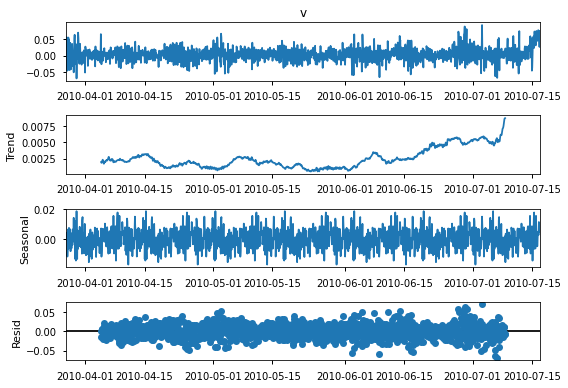

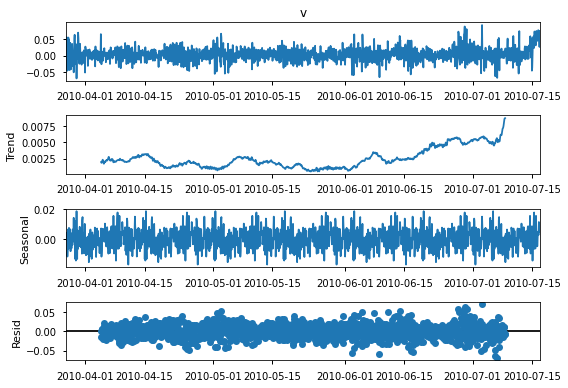

In [72]:
decomposition.plot()